In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from allensdk.brain_observatory.sync_dataset import Dataset
import h5py

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times

In [4]:
%matplotlib notebook

## Load data

In [5]:
dfolder = r'F:\psi_exp\mouse669117\pilot_ur_2023-03-31_11-51-53\experiment1\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder, preprocess=False)

Experiment type: electrical stimulation


## Load movies

In [6]:
pupil_video = Movie(
    filepath = exp.pupilmovie_file,
    sync_filepath = exp.sync_file,
    sync_channel = 'eyetracking'
)
pupil_ts = pupil_video.sync_timestamps
body_video = Movie(
    filepath = exp.bodymovie_file,
    sync_filepath = exp.sync_file,
    sync_channel = 'behavior'
)
body_ts = body_video.sync_timestamps

C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:41: UserWarning: NONMATCHING timestamp counts
There are 174750 timestamps in sync and 174864 timestamps in the associated camera file
these should match
  len(self.sync_timestamps), len(self.timestamps_from_file)))
C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:41: UserWarning: NONMATCHING timestamp counts
There are 348786 timestamps in sync and 349014 timestamps in the associated camera file
these should match
  len(self.sync_timestamps), len(self.timestamps_from_file)))


## Get video info

In [7]:
print(body_video.frame_count)
print(len(body_ts))
print(len(body_ts) - body_video.frame_count)

349014
348786
-228


In [8]:
len(body_video.sync_timestamps)

348786

In [9]:
len(body_video.timestamps_from_file)

349014

In [8]:
print(body_ts[:5])
print(body_ts[-5:])

[11.09972 11.11404 11.12773 11.14334 11.16025]
[3846.45251 3846.46924 3846.48593 3846.50251 3846.52495]


In [19]:
print(228 / (1/(np.mean(np.diff(body_ts[2:20])))))

3.7957976470588064


In [9]:
print(pupil_video.frame_count)
print(len(pupil_ts))
print(len(pupil_ts) - pupil_video.frame_count)

174864
174750
-114


In [10]:
print(pupil_ts[:5])
print(pupil_ts[-5:])

[13.84473 13.85653 13.88744 13.92065 13.95399]
[5842.39681 5842.4341  5842.46362 5842.49684 5842.53179]


In [11]:
print(np.diff(pupil_ts[:30]))

[0.0118  0.03091 0.03321 0.03334 0.03336 0.03338 0.03398 0.03273 0.03344
 0.03716 0.02943 0.03328 0.03433 0.0323  0.03327 0.0334  0.0333  0.03329
 0.03334 0.03799 0.02866 0.0335  0.03415 0.03244 0.03334 0.03332 0.03331
 0.03329 0.03334]


In [12]:
med_pupil_diff = np.median(np.diff(pupil_ts))
print(med_pupil_diff)

0.03333000000020547


In [64]:
0.00217 + 0.01979

0.02196

In [13]:
delta = 0.04
print(np.sum(np.diff(pupil_ts) < med_pupil_diff - delta))
print(np.sum(np.diff(pupil_ts) > med_pupil_diff * 4.6))

0
11


In [14]:
for indi in np.nonzero(np.diff(pupil_ts) > med_pupil_diff * 4.6)[0]:
    print(np.diff(pupil_ts)[indi:indi+5])

[0.21993 0.00176 0.01139 0.03387 0.03284]
[0.19945 0.00186 0.03203 0.0334  0.03334]
[0.3566  0.00222 0.04037 0.03331 0.03322]
[0.18859 0.00201 0.04288 0.03324 0.03331]
[0.91888 0.00207 0.01188 0.03357 0.03313]
[0.16212 0.00223 0.03564 0.03325 0.03336]
[0.32928 0.00208 0.03532 0.03332 0.03334]
[0.32149 0.0018  0.01023 0.03304 0.03326]
[0.16303 0.00332 0.03365 0.0333  0.03335]
[0.16856 0.00245 0.02923 0.03319 0.0334 ]
[0.23303 0.00192 0.03159 0.03348 0.03332]


### Frame mismatch...try to align with running?

In [10]:
run_signal, run_timestamps = exp.load_running()

In [11]:
print(run_timestamps[:10])
print(body_ts[:10])
print(pupil_ts[:10])

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]
[13.89963 13.91051 13.91384 13.93019 13.94683 13.9635  13.98027 13.99688
 14.01381 14.03016]
[13.84473 13.85653 13.88744 13.92065 13.95399 13.98735 14.02073 14.05471
 14.08744 14.12088]


<IPython.core.display.Javascript object>


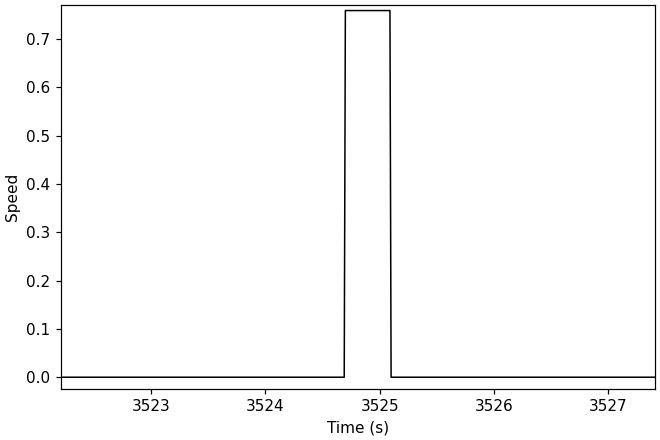

Text(0, 0.5, 'Speed')

In [21]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.plot(run_timestamps, run_signal, color='k', linewidth=1)
ax.set_xlim([run_timestamps[0], run_timestamps[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Speed')

In [22]:
time_int = [3520.5, 3529.]
movietimes = body_video.sync_timestamps[
    np.nonzero((body_video.sync_timestamps > time_int[0]) & (body_video.sync_timestamps < time_int[1]))[0]
]
runinds = np.nonzero((run_timestamps > time_int[0]) & (run_timestamps < time_int[1]))[0]

In [23]:
def update(frame):
    current_time = movietimes[frame]
    
    # body cam movie
    bax.set_data(body_video.get_frame(time=current_time))
    
    # eeg plot
    spline.set_data([current_time, current_time], [0,1])
    
    return fig

<IPython.core.display.Javascript object>


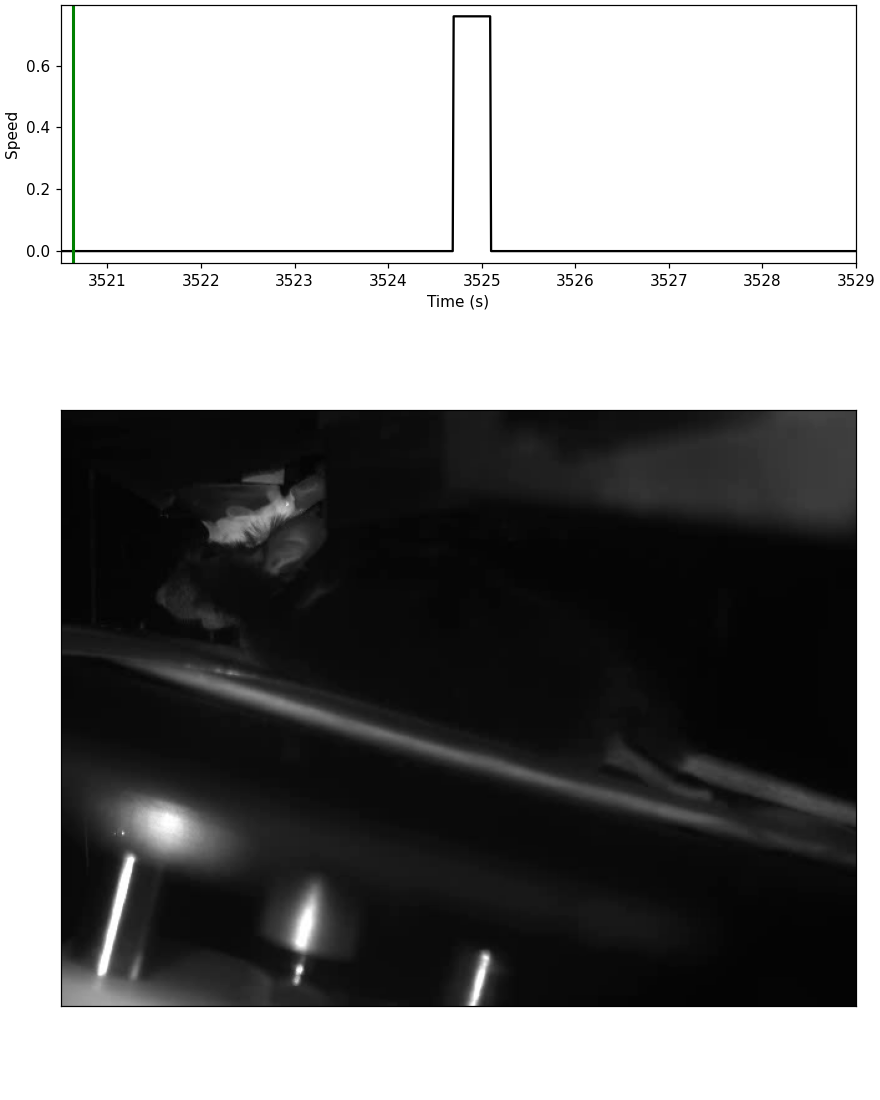

In [24]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8,10), constrained_layout=True, gridspec_kw={'height_ratios': [1,3]})

# running speed
axs[0].plot(run_timestamps[runinds], run_signal[runinds], 'k')
axs[0].set_xlim(time_int)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Speed')
spline = axs[0].axvline(x=movietimes[0], color='green', linewidth=2)

# body cam movie
bax = axs[1].imshow(body_video.get_frame(time=movietimes[0]))
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)

anim = animation.FuncAnimation(fig, update, init_func=None, frames=len(movietimes), interval=66, blit=False)

#### Try getting sync_timestamps a different way

In [37]:
pupil_ts_fromsync = get_sync_frame_times(
    sync_data = exp.sync_file, # can pass file path OR sync_dataset
    channel_name = 'eyetracking',
    threshold = 0.00073, # default=0.0001, removes short sync transients
)
print(len(pupil_ts_fromsync))
print(pupil_ts_fromsync[:5])

159417
[15.34189 15.40413 15.40595 15.43503 15.46828]


In [38]:
print(pupil_ts_fromsync[-5:])

[5332.38204 5332.41067 5332.44403 5332.47743 5332.51495]


#### Look at sync dataset

In [13]:
sync_data = Dataset(exp.sync_file)

In [14]:
prising = sync_data.get_rising_edges('eyetracking')
print(len(prising))
pfalling = sync_data.get_falling_edges('eyetracking')
print(len(pfalling))

159425
159425


In [78]:
print(sync_data._line_to_bit('eyetracking'))

8


In [79]:
timex = sync_data.get_all_times(units='sec')
print(len(timex))
bitdata = sync_data.get_bit(8)
print(len(bitdata))

1472247


1472247

In [81]:
print(timex[:5])

[ 0.      10.74445 10.78105 10.80037 10.81503]


<IPython.core.display.Javascript object>


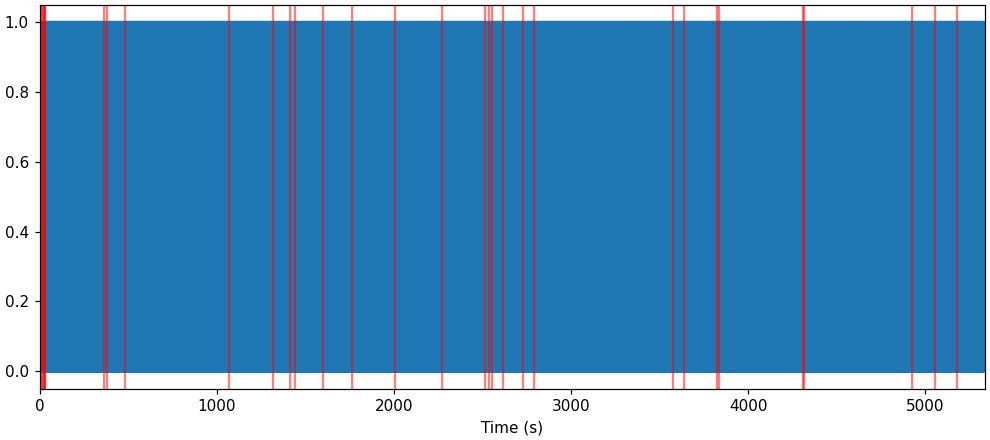

In [85]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)
ax.step(timex, bitdata)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')

for indi in np.nonzero(np.diff(pupil_ts) > med_pupil_diff * 3)[0]:
    ax.axvline(pupil_ts[indi], color='r', alpha=0.5)

# Older stuff...trying to learn how to get video info

### Use Movie class

In [16]:
sync_file = r"T:\zap-n-zip\EEG_exp\mouse621102\opto_cortical_pilot_2022-06-03_12-09-01\experiment1\recording1\mouse621102220603120827.sync"

In [17]:
sync_data = Dataset(sync_file)

### Look for rising and falling edges in sync file

In [18]:
test_ch = 'eyetracking'
rising = sync_data.get_rising_edges(test_ch)
falling = sync_data.get_falling_edges(test_ch)

In [19]:
print(len(rising))
print(len(falling))

0
0


In [7]:
sync_data.meta_data['ni_daq']['counter_output_freq']

100000.0

In [8]:
sync_ch = 'eyetracking' # sync channel name? for sync timestamps?

In [9]:
print(sync_data.line_labels)

['barcodes', 'opto_sync', 'frames', 'behavior_sweep', 'photodiode', 'sweep', '', 'behavior_vsync', 'eyetracking', 'behavior', 'rotA', 'rotB', 'estim_sync', 'estim_sweep', '', '', '', 'opto_sweep', 'opto_trial', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [10]:
movie_class = Movie(filepath=movie_filepath, sync_filepath=sync_file, sync_channel='eyetracking')

C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:116: UserWarning: channel eyetracking in sync file is empty
  'channel {} in sync file is empty'.format(channel_name))


In [12]:
movie_class.frame_count

265638

In [13]:
movie_class.width

640

In [14]:
movie_class.height

480

In [13]:
help(movie_class)

Help on Movie in module tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies object:

class Movie(builtins.object)
 |  a class for loading movies captured with videomon
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filepath, sync_filepath=None, sync_channel=None, edge='rising', sync_timestamps=None, h5_filename=None, lazy_load=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_frame(self, frame=None, time=None, timestamps='sync')
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



#### Give the movie object a time (in the master clock) and it will find the correct frame.

In [38]:
testframe = movie_class.get_frame(frame=0)

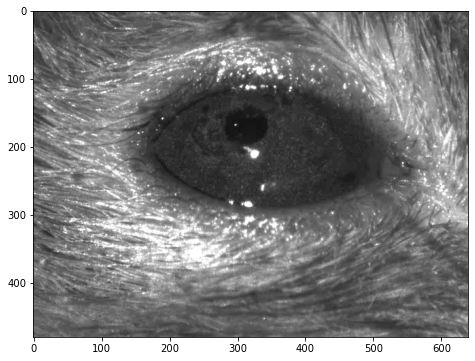

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(testframe)

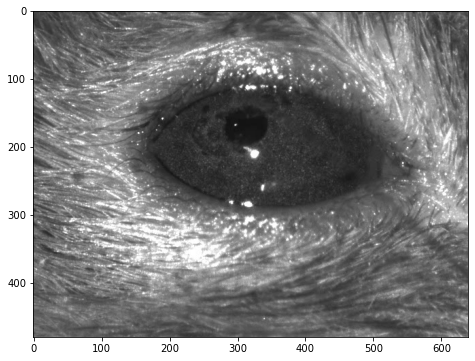

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(movie_class.get_frame(frame=15))

#### The code example I followed just looped through the relevant times and grabbed the nearest frame in time using the movie.get_frame(time=time_i) functions.

In [15]:
help(movie_class.get_frame)

Help on method get_frame in module tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies:

get_frame(frame=None, time=None, timestamps='sync') method of tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies.Movie instance



In [16]:
dir(movie_class)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_array',
 '_lazy_load',
 'array',
 'cap',
 'frame_count',
 'get_frame',
 'height',
 'sync_timestamps',
 'timestamps_from_file',
 'width']

In [17]:
syncts = movie_class.sync_timestamps

In [19]:
syncts

In [18]:
1/np.mean(np.diff(syncts))

29.96210520977723

In [28]:
movie_class.frame_count

107958

In [51]:
testts = get_sync_frame_times(sync_data, sync_ch, edge='rising', first_index=0, threshold=0.001, clean=True, verbose=False)

In [52]:
len(testts)

42021

## Load the h5 file

In [20]:
timestamp_file = h5py.File(movie_filepath.replace('.avi','.h5'), 'r')

In [21]:
timestamp_file.keys()

<KeysViewHDF5 ['camera_config', 'frame_intervals', 'video_metadata']>

In [22]:
print(timestamp_file['camera_config'])

<HDF5 dataset "camera_config": shape (), type "|S2">


In [23]:
help(timestamp_file)

Help on File in module h5py._hl.files object:

class File(h5py._hl.group.Group)
 |  Represents an HDF5 file.
 |  
 |  Method resolution order:
 |      File
 |      h5py._hl.group.Group
 |      h5py._hl.base.HLObject
 |      h5py._hl.base.CommonStateObject
 |      h5py._hl.base.MutableMappingHDF5
 |      h5py._hl.base.MappingHDF5
 |      collections.abc.MutableMapping
 |      collections.abc.Mapping
 |      collections.abc.Collection
 |      collections.abc.Sized
 |      collections.abc.Iterable
 |      collections.abc.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __init__(self, name, mode=None, driver=None, libver=None, userblock_size=None, swmr=False, rdcc_nslots=None, rdcc_nbytes=None, rdcc_w0=None, track_order=None, **kwds)
 |      Create a new file object.
 |      
 |      See the h5py user guide for a detailed explanation of the options.
 |      
 |      name
 |          Name of the file on disk, o

In [24]:
video_ts = np.hstack((0, np.cumsum(timestamp_file['frame_intervals'])))

In [25]:
video_ts[0:5]

array([0.        , 0.03336675, 0.06678763, 0.100051  , 0.13324465])

In [26]:
1/np.mean(np.diff(video_ts[0:5]))

30.019966623610745

In [27]:
len(video_ts)

107958